In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['JNJ.csv']))
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

Saving JNJ.csv to JNJ.csv


In [ ]:
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].values
features = np.nan_to_num(features)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

In [ ]:
def create_sequences(data, sequence_length=60):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 3])
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_features, sequence_length)
train_size = int(len(X) * 0.8)
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2]), kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(50, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

In [ ]:
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/50
176/176 [==============================] - 36s 154ms/step - loss: 0.5466 - val_loss: 0.2114 - lr: 0.0010
Epoch 2/50
176/176 [==============================] - 27s 152ms/step - loss: 0.2878 - val_loss: 0.1648 - lr: 0.0010
Epoch 3/50
176/176 [==============================] - 23s 132ms/step - loss: 0.1828 - val_loss: 0.1291 - lr: 0.0010
Epoch 4/50
176/176 [==============================] - 24s 138ms/step - loss: 0.1292 - val_loss: 0.0988 - lr: 0.0010
Epoch 5/50
176/176 [==============================] - 25s 144ms/step - loss: 0.0975 - val_loss: 0.0822 - lr: 0.0010
Epoch 6/50
176/176 [==============================] - 25s 143ms/step - loss: 0.0779 - val_loss: 0.0704 - lr: 0.0010
Epoch 7/50
176/176 [==============================] - 23s 131ms/step - loss: 0.0640 - val_loss: 0.0593 - lr: 0.0010
Epoch 8/50
176/176 [==============================] - 25s 142ms/step - loss: 0.0534 - val_loss: 0.0486 - lr: 0.0010
Epoch 9/50
176/176 [==============================] - 25s 144ms/step - l

In [ ]:
predicted_prices = model.predict(test_X)
dummy = np.zeros((predicted_prices.shape[0], scaled_features.shape[1]))
dummy[:, 3] = predicted_prices[:, 0]
predicted_prices = scaler.inverse_transform(dummy)[:, 3]

dummy_real = np.zeros((test_y.shape[0], scaled_features.shape[1]))
dummy_real[:, 3] = test_y
real_prices = scaler.inverse_transform(dummy_real)[:, 3]

98/98 [==============================] - 10s 76ms/step


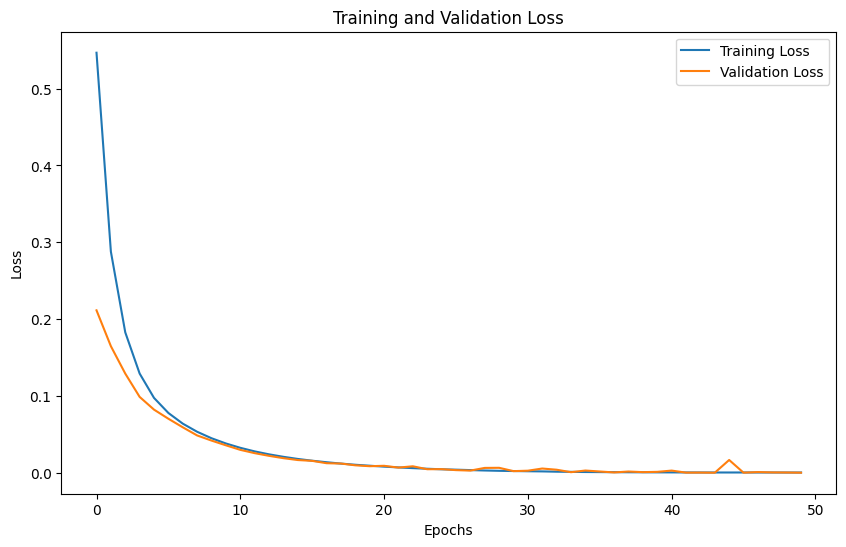

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

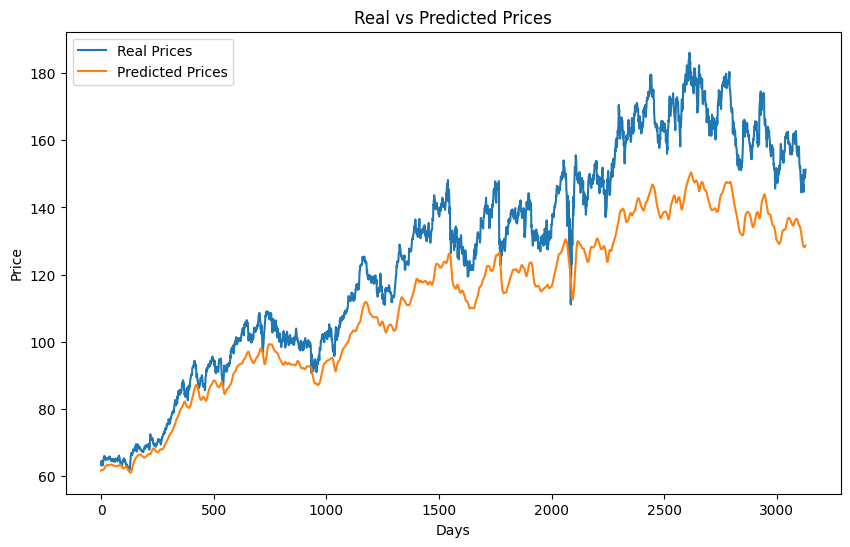

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(real_prices, label='Real Prices')
plt.plot(predicted_prices, label='Predicted Prices')
plt.title('Real vs Predicted Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()